# Instruction for running the notebook
please download all the files in the github repository, and run all the chunks manually.

## Load required package

In [4]:
%pip install tensorflow==2.12.0
%pip install shap

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 166.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Read the data

Load the dataset and print the head, info, and the shape.

In [7]:
used_car_data = pd.read_csv('./data/vehicles.csv')
print("first 5 rows of the dataset:\n")
print(used_car_data.head())

first 5 rows of the dataset:

           id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN      

In [8]:
print(f"information of the dataset: {used_car_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [9]:
print(f"shape of the dataset: {used_car_data.shape}")

shape of the dataset: (426880, 26)


## Data Preprocessing

check null value, duplicates, and outliers in the data.  
Used different methods to tackle with null values in different columns, drop duplicates, and tackle the outliers after finishing feature engineering since some model are robust to outliers and some are not.

In [10]:
# check duplicated
print(f"Number of duplicated rows in the dataset: {used_car_data.duplicated().sum()}\n")
# drop duplicated data
used_car_data = used_car_data.drop_duplicates(keep='first')

# check null values
print(f"null values in each column: \n{used_car_data.isna().sum()}\n")

# addressing missing values
# drop county column since it is whole empty
used_car_data = used_car_data.drop(['county'], axis=1)
# drop na since small number of rows: year, manufacturer, model, posting_date
used_car_data = used_car_data.dropna(subset=['year', 'manufacturer', 'model','posting_date'])
# # fill with the values that has the same model name: manufacuter; check the null values and use openai to fill the blank
# def fill_manufacturer(row):
#     if pd.isna(row['manufacturer']) and pd.notna(row['model']):
#         model_group = used_car_data.loc[used_car_data['model'] == row['model'], 'manufacturer']
#         if not model_group.mode().empty:
#             return model_group.mode().iloc[0]
#     return row['manufacturer']
# # Apply the function to the dataset
# used_car_data['manufacturer'] = used_car_data.apply(fill_manufacturer, axis=1)
# fill with the values that has the same model and manufacturer name: cylinders, transmission, drive, size, type
fill_cols = ['cylinders', 'transmission', 'drive', 'size', 'type']
for col in fill_cols:
    used_car_data[col] = used_car_data.groupby(['manufacturer', 'model'])[col].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown")
    )
# fill with mean value in the same year: odometer
used_car_data['odometer'] = used_car_data.groupby('year')['odometer'].transform(
    lambda x: x.fillna(x.mean())
)
# fill na with unkown for categorical data: paint_color, title_status, fuel, condition
cat_cols_to_fill = ['paint_color', 'title_status', 'fuel', 'condition']
for col in cat_cols_to_fill:
    used_car_data[col] = used_car_data[col].fillna("Unknown")
# do not deal with null values: VIN, image_url, description, lat, long

Number of duplicated rows in the dataset: 0

null values in each column: 
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64



In [11]:
# 2nd check with missing values in each column
print(f"null values in each column: \n{used_car_data.isna().sum()}\n")

# drop na since small number of rows: odometer
used_car_data = used_car_data.dropna(subset=['odometer'])

# 2nd check duplicated
print(f"Number of duplicated rows in the dataset: {used_car_data.duplicated().sum()}\n")
# drop duplicated data
used_car_data = used_car_data.drop_duplicates(keep='first')

null values in each column: 
id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer         0
model                0
condition            0
cylinders            0
fuel                 0
odometer            12
title_status         0
transmission         0
VIN             147562
drive                0
size                 0
type                 0
paint_color          0
image_url            0
description          2
state                0
lat               6155
long              6155
posting_date         0
dtype: int64

Number of duplicated rows in the dataset: 0



In [12]:
# last check with missing value
print(f"null values in each column: \n{used_car_data.isna().sum()}\n")

null values in each column: 
id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer         0
model                0
condition            0
cylinders            0
fuel                 0
odometer             0
title_status         0
transmission         0
VIN             147562
drive                0
size                 0
type                 0
paint_color          0
image_url            0
description          2
state                0
lat               6155
long              6155
posting_date         0
dtype: int64



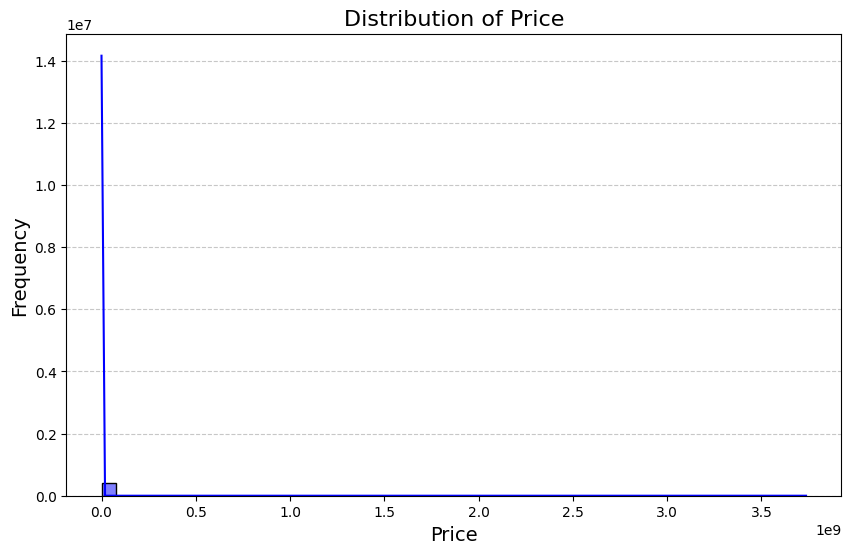

In [13]:
# Plot the distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

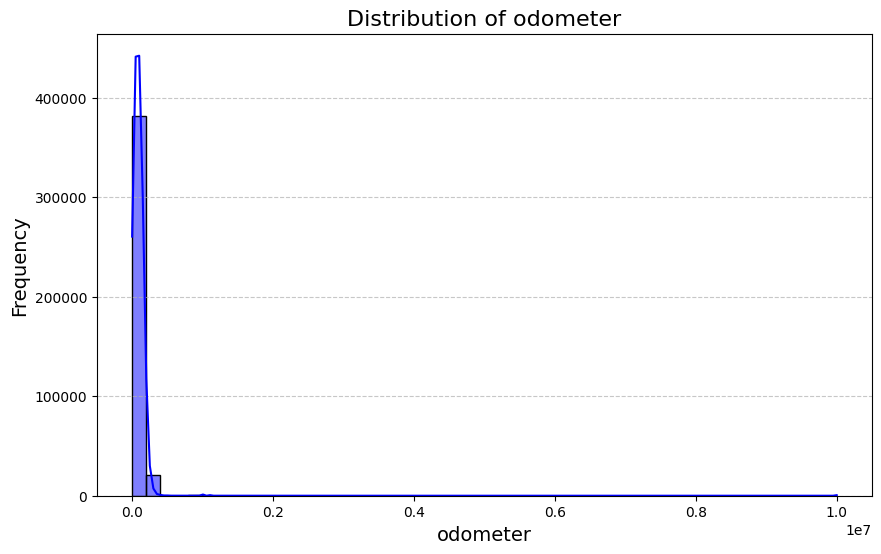

In [14]:
# Plot the distribution of odometer
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['odometer'], bins=50, kde=True, color='blue')
plt.title('Distribution of odometer', fontsize=16)
plt.xlabel('odometer', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# deal with price outliers
price_percentile25 = used_car_data['price'].quantile(0.25)
price_percentile75 = used_car_data['price'].quantile(0.75)
price_iqr = price_percentile75 - price_percentile25
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = price_percentile25 - 1.5 * price_iqr
print("total outliers - ",len(used_car_data)-len(used_car_data[(used_car_data['price'] < price_upper_limit) & (used_car_data['price'] > price_lower_limit)]))
# Capping outliers of price
used_car_data['price'] = np.clip(used_car_data['price'], price_lower_limit, price_upper_limit)

# deal with odometer outliers
odometer_percentile25 = used_car_data['odometer'].quantile(0.25)
odometer_percentile75 = used_car_data['odometer'].quantile(0.75)
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = odometer_percentile25 - 1.5 * odometer_iqr
print("total outliers - ",len(used_car_data)-len(used_car_data[(used_car_data['odometer'] < odometer_upper_limit) & (used_car_data['odometer'] > odometer_lower_limit)]))
# Capping outliers of price
used_car_data['odometer'] = np.clip(used_car_data['odometer'], odometer_lower_limit, odometer_upper_limit)

# check outliers with categorical data: manufacutrer, model, condition, cylinders, fuel, title_status, transmission, drive, size, type, paint_color
categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 
                       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
for col in categorical_columns:
    print(f"Unique values and counts for {col}:")
    print(used_car_data[col].value_counts())
    print("\n")

total outliers -  7016
total outliers -  3351
Unique values and counts for manufacturer:
manufacturer
ford               70269
chevrolet          54139
toyota             33944
honda              21155
nissan             18948
jeep               18873
ram                17367
gmc                16576
bmw                14584
dodge              13438
mercedes-benz      11696
hyundai            10278
subaru              9457
volkswagen          9260
kia                 8415
lexus               8150
audi                7532
cadillac            6880
chrysler            5981
acura               5948
buick               5447
mazda               5391
infiniti            4773
lincoln             4174
volvo               3278
mitsubishi          3277
mini                2361
pontiac             2248
jaguar              1921
rover               1801
porsche             1351
mercury             1165
saturn              1070
alfa-romeo           897
tesla                852
fiat                 78

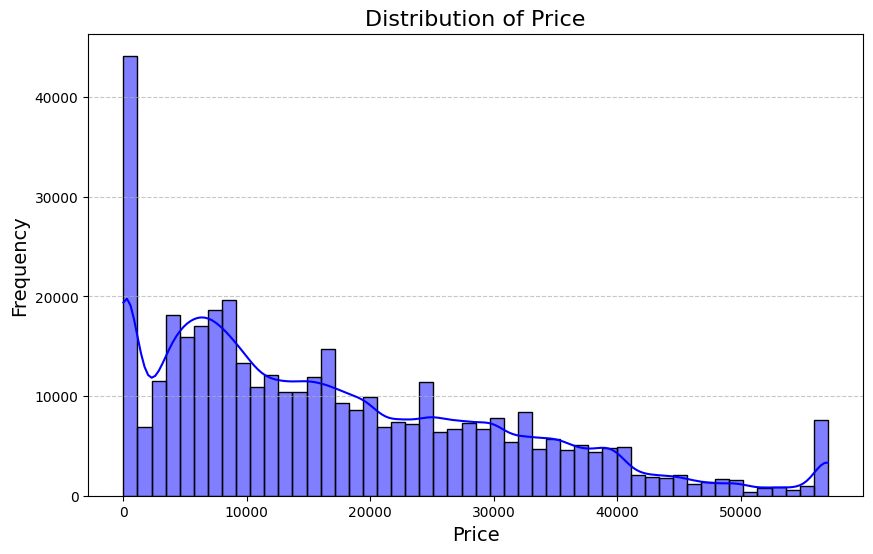

In [16]:
# Plot the distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

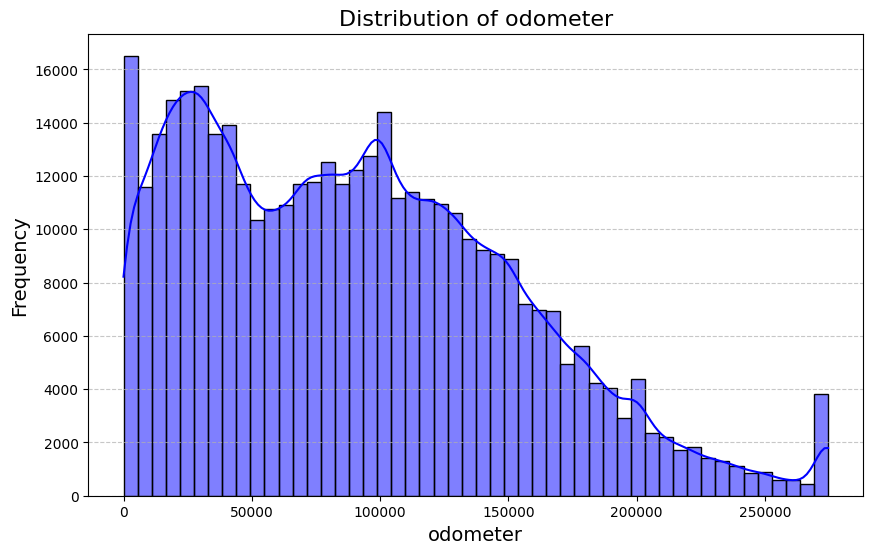

In [17]:
# Plot the distribution of odometer
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['odometer'], bins=50, kde=True, color='blue')
plt.title('Distribution of odometer', fontsize=16)
plt.xlabel('odometer', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Feature Engineering

Create new columns that contain the length of the description, posting year, and posting month for further training


In [18]:
# create new column "des_len" that is the length of the "description" value
used_car_data['des_len'] = used_car_data['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

# Convert posting_date from object to String
used_car_data['posting_date'] = used_car_data['posting_date'].astype(str)

# create new colum "posting_year" that extract the year in the "posting_date" column
used_car_data['posting_year'] = used_car_data['posting_date'].str.split('-').str[0]
used_car_data['posting_year'] = used_car_data['posting_year'].astype(int)

# create new colum "posting_month" that extract the month in the "posting_date" column
used_car_data['posting_month'] = used_car_data['posting_date'].str.split('-').str[1]

# create new colum "year_used" that calculate by posting_year - year, if any of the value is null, return na
used_car_data['year_used'] = used_car_data.apply(
    lambda row: row['posting_year'] - row['year'] if pd.notna(row['posting_year']) and pd.notna(row['year']) else pd.NA,
    axis=1
)

# fill the na in the year_used with the mean of the rest
mean_year_used = used_car_data['year_used'].dropna().mean()
used_car_data['year_used'] = used_car_data['year_used'].fillna(mean_year_used)

# drop unused columns: id, url, region_url, year, VIN, image_url, description, state, lat, long, posting_date
columns_to_drop = ['id', 'url', 'region_url', 'year', 'VIN', 'image_url', 'description', 
                   'state', 'lat', 'long', 'posting_date']
used_car_data = used_car_data.drop(columns=columns_to_drop, axis=1)

In [19]:
used_car_data = used_car_data.reset_index(drop=True)
used_car_data.head()

,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,des_len,posting_year,posting_month,year_used
0,auburn,33590.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,Unknown,pickup,white,4347,2021,05,7.0
1,auburn,22590.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,full-size,pickup,blue,4560,2021,05,11.0
2,auburn,39590.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,Unknown,pickup,red,4507,2021,05,1.0
3,auburn,30990.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,full-size,pickup,red,4663,2021,05,4.0
4,auburn,15000.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,66,2021,05,8.0


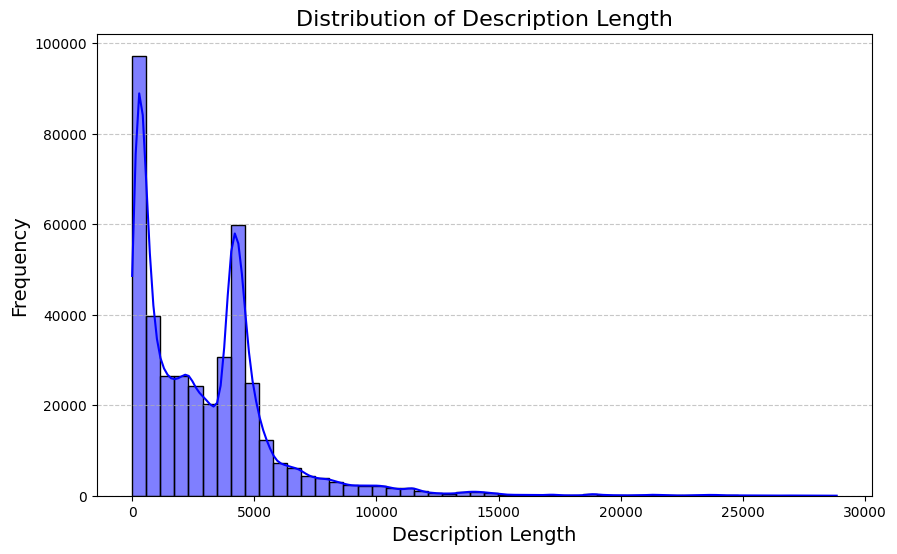

In [20]:
# Plot the distribution of des_len
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['des_len'], bins=50, kde=True, color='blue')
plt.title('Distribution of Description Length', fontsize=16)
plt.xlabel('Description Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

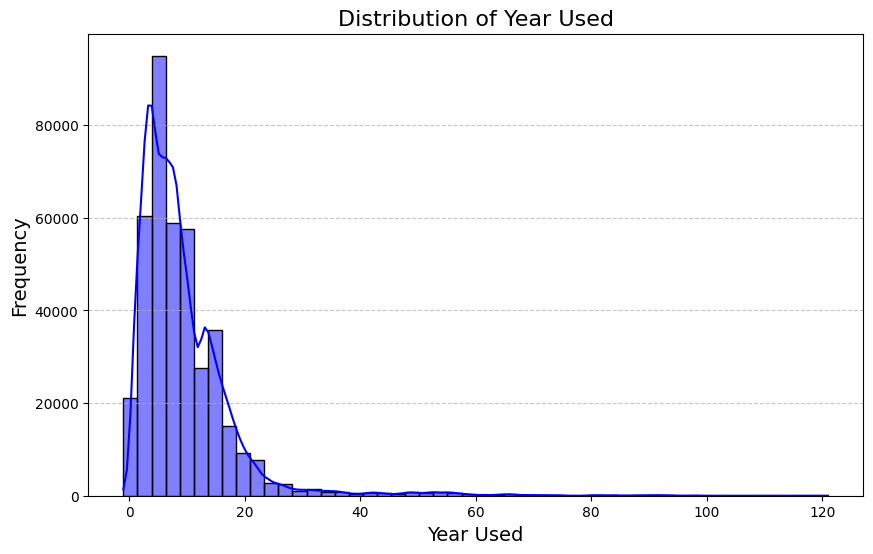

In [21]:
# Plot the distribution of year_used
plt.figure(figsize=(10, 6))
sns.histplot(used_car_data['year_used'], bins=50, kde=True, color='blue')
plt.title('Distribution of Year Used', fontsize=16)
plt.xlabel('Year Used', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
# deal with price des_len
des_percentile25 = used_car_data['des_len'].quantile(0.25)
des_percentile75 = used_car_data['des_len'].quantile(0.75)
des_iqr = des_percentile75 - des_percentile25
des_upper_limit = des_percentile75 + 1.5 * des_iqr
des_lower_limit = des_percentile25 - 1.5 * des_iqr
print("total outliers - ",len(used_car_data)-len(used_car_data[(used_car_data['des_len'] < des_upper_limit) & (used_car_data['des_len'] > des_lower_limit)]))
# Capping outliers of price
used_car_data['des_len'] = np.clip(used_car_data['des_len'], des_lower_limit, des_upper_limit)

# deal with odometer year_used
yu_percentile25 = used_car_data['year_used'].quantile(0.25)
yu_percentile75 = used_car_data['year_used'].quantile(0.75)
yu_iqr = yu_percentile75 - yu_percentile25
yu_upper_limit = yu_percentile75 + 1.5 * yu_iqr
yu_lower_limit = yu_percentile25 - 1.5 * yu_iqr
print("total outliers - ",len(used_car_data)-len(used_car_data[(used_car_data['year_used'] < yu_upper_limit) & (used_car_data['year_used'] > yu_lower_limit)]))
# Capping outliers of price
used_car_data['year_used'] = np.clip(used_car_data['year_used'], yu_lower_limit, yu_upper_limit)

total outliers -  11593
total outliers -  15853


In [23]:
used_car_data.shape

(404008, 18)

In [42]:
# shrink the dataset to around 30,000 rows for model training efficiency
used_car_data_sampled = used_car_data.sample(n=100000, random_state=42)

# Check the shape of the sampled dataset
print(used_car_data_sampled.shape)

(100000, 18)


## Model Training

Deal with outliers(categorical and numerical):  
1. categorical columns that contains more than 15 category: lower than 1% group are reassign to "others"
2. numerical column "price": log transformation for Linear, Lasso, and Ridge
3. other numerical columns: standardize  
train test split  
hyperparameter tunning (evaluate by r2)  
training(linear, lasso, ridge, knn, svm, random forest, gradient boosting, feedforward neural network)  
evaluate model performance with mae, rmse, and r2

In [25]:
def Linears(data, ml_model):
    # deal with categorical outliers
    categorical_columns = ['manufacturer', 'model', 'region']
    # if the category has lower than 1% observations, then change the category into "others"
    for col in categorical_columns:
        value_counts = data[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < 0.01].index
        data[col] = data[col].replace(rare_categories, 'others')
        
    # log transformation for the price
    data['log_price'] = np.log1p(data['price'])
    
    # one-hot encoding for the categoical data
    categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                           'fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'posting_year', 'posting_month',]
    categorical_transformer = OneHotEncoder(sparse_output = False, drop = 'first')
    
    # standardize the data
    numerical_columns = ['odometer', 'des_len', 'year_used']
    numerical_transformer = StandardScaler()

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )
    
    # train test split by the ratio of 8:2
    X = data.drop(columns=['price', 'log_price'])
    y = data['log_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                                                        
    # train the model with cross-validation hyperparameter tunning(choose the best parameter with auc), cv=10
    # linear, lasso, and ridge
    if ml_model == 'linear':
        model = LinearRegression()
        # param_grid = {}
    elif ml_model == 'lasso':
        model = Lasso()
        # param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
    elif ml_model == 'ridge':
        model = Ridge()
        # param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
    else:
        raise ValueError("Invalid model type. Choose 'linear', 'lasso', or 'ridge'.")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Hyperparameter tuning with cross-validation
    # grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
    pipeline.fit(X_train, y_train)

    # Best model
    # best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Reverse log transformation
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    r2 = r2_score(y_test, y_pred)
    
    # print the best parameters, and the evaluations scores
    # print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    
    return mae, rmse, r2
    

In [38]:
def DistanceModel(data, ml_model):

    # Handle categorical outliers: Combine categories with <1% observations into "others"
    categorical_columns = ['manufacturer', 'model', 'region']
    
    for col in categorical_columns:
        value_counts = data[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < 0.01].index
        data[col] = data[col].replace(rare_categories, 'others')

    # Define preprocessing steps
    # One-hot encoding for categorical variables
    categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                           'fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'posting_year', 'posting_month',]
    categorical_transformer = OneHotEncoder(sparse_output = True, drop = 'first')

    # Standardize numerical variables
    numerical_columns = ['odometer', 'des_len', 'year_used']
    numerical_transformer = StandardScaler()

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    # Train-test split (8:2 ratio)
    X = data.drop(columns=['price'])
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model based on input
    if ml_model == 'knn':
        model = KNeighborsRegressor(n_neighbors=5, weights='uniform')
        # param_grid = {'model__n_neighbors': [3, 5, 7, 9, 11],
        #               'model__weights': ['uniform', 'distance']}
    elif ml_model == 'svm':
        model = SVR(C=1.0, kernel='rbf', gamma='scale')
        # param_grid = {'model__C': [0.1, 1, 10, 100],
        #               'model__kernel': ['linear', 'rbf', 'poly'],
        #               'model__gamma': ['scale', 'auto']}
    else:
        raise ValueError("Invalid model type. Choose 'knn' or 'svm'.")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Hyperparameter tuning with cross-validation
    # grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
    pipeline.fit(X_train, y_train)

    # Best model
    # best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print results
    # print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # # Preprocess training data for SHAP
    # X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

    # # Define SHAP explainer
    # def pipeline_predict(data):
    #     return pipeline.named_steps['model'].predict(data)

    # explainer = shap.KernelExplainer(pipeline_predict, X_train_transformed)
    # shap_values = explainer.shap_values(X_train_transformed[:100])  # Limit to 100 rows for performance

    # # Plot SHAP summary
    # shap.summary_plot(shap_values, X_train_transformed[:100])
    
    return mae, rmse, r2


In [34]:
def RandomForest(data):
    
    # Define preprocessing steps
    # One-hot encoding for categorical variables
    categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                           'fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'posting_year', 'posting_month',]
    categorical_transformer = OneHotEncoder(sparse_output = True, drop = 'first')

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    # Train-test split (8:2 ratio)
    X = data.drop(columns=['price'])
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the Random Forest model
    model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
    # param_grid = {
    #     'model__n_estimators': [100, 200, 300],
    #     'model__max_depth': [None, 10, 20, 30],
    #     'model__min_samples_split': [2, 5, 10],
    #     'model__min_samples_leaf': [1, 2, 4]
    # }

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Hyperparameter tuning with cross-validation
    # grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
    pipeline.fit(X_train, y_train)

    # Best model
    # best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print results
    # print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    
    return mae, rmse, r2


In [40]:
def GradientBoosting(data):

    # Define preprocessing steps
    # One-hot encoding for categorical variables
    categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                           'fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'posting_year', 'posting_month',]
    categorical_transformer = OneHotEncoder(sparse_output = True, drop = 'first')

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    # Train-test split (8:2 ratio)
    X = data.drop(columns=['price'])
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the Gradient Boosting model
    model = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=4, min_samples_split=10,
                                      min_samples_leaf=4)
    # param_grid = {
    #     'model__n_estimators': [100, 200, 300],
    #     'model__learning_rate': [0.01, 0.1, 0.2],
    #     'model__max_depth': [3, 5, 7],
    #     'model__min_samples_split': [2, 5, 10],
    #     'model__min_samples_leaf': [1, 2, 4]
    # }

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Hyperparameter tuning with cross-validation
    # grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
    pipeline.fit(X_train, y_train)

    # Best model
    # best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print results
    # print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return mae, rmse, r2

In [29]:
# def build_ffnn(input_dim):
#     """Builds a Feedforward Neural Network model."""
#     model = Sequential([
#         Dense(128, activation='relu', input_dim=input_dim),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         Dropout(0.2),
#         Dense(1, activation='linear')
#     ])
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# def Feedforwardnn(data):
#     # Handle categorical outliers: Combine categories with <1% observations into "others"
#     categorical_columns = ['manufacturer', 'model']
    
#     for col in categorical_columns:
#         value_counts = data[col].value_counts(normalize=True)
#         rare_categories = value_counts[value_counts < 0.01].index
#         data[col] = data[col].replace(rare_categories, 'others')

#     # Define preprocessing steps
#     # One-hot encoding for categorical variables
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     # Standardize numerical variables
#     numerical_columns = ['odometer']
#     numerical_transformer = StandardScaler()

#     # Combine preprocessors in a column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numerical_transformer, numerical_columns),
#             ('cat', categorical_transformer, categorical_columns)
#         ]
#     )

#     # Train-test split (8:2 ratio)
#     X = data.drop(columns=['price'])
#     y = data['price']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Preprocess the data
#     X_train_transformed = preprocessor.fit_transform(X_train)
#     X_test_transformed = preprocessor.transform(X_test)

#     # Build the model
#     input_dim = X_train_transformed.shape[1]
#     model = KerasRegressor(build_fn=build_ffnn, input_dim=input_dim, epochs=50, batch_size=32, verbose=0)

#     # Train the model
#     model.fit(X_train_transformed, y_train)

#     # Predict on the test set
#     y_pred = model.predict(X_test_transformed)

#     # Evaluate the model
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     r2 = r2_score(y_test, y_pred)

#     # Print results
#     print(f"Mean Absolute Error (MAE): {mae:.2f}")
#     print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#     print(f"R^2 Score: {r2:.2f}")
    
#     return mae, rmse, r2

In [43]:
# Run models
linear_mae, linear_rmse, linear_r2 = Linears(used_car_data_sampled, "linear")
lasso_mae, lasso_rmse, lasso_r2 = Linears(used_car_data_sampled, "lasso")
ridge_mae, ridge_rmse, ridge_r2 = Linears(used_car_data_sampled, "ridge")

Mean Absolute Error (MAE): 10759.79
Root Mean Squared Error (RMSE): 15322.43
R^2 Score: 0.09
Mean Absolute Error (MAE): 13104.10
Root Mean Squared Error (RMSE): 18011.89
R^2 Score: -0.00
Mean Absolute Error (MAE): 10761.17
Root Mean Squared Error (RMSE): 15323.97
R^2 Score: 0.09


In [44]:
knn_mae, knn_rmse, knn_r2 = DistanceModel(used_car_data_sampled, 'knn')

Mean Absolute Error (MAE): 4982.83
Root Mean Squared Error (RMSE): 8459.83
R^2 Score: 0.64


In [45]:
svm_mae, svm_rmse, svm_r2 = DistanceModel(used_car_data_sampled, 'svm')

Mean Absolute Error (MAE): 9527.19
Root Mean Squared Error (RMSE): 12759.80
R^2 Score: 0.18


In [46]:
rf_mae, rf_rmse, rf_r2 = RandomForest(used_car_data_sampled)

Mean Absolute Error (MAE): 6810.74
Root Mean Squared Error (RMSE): 10150.78
R^2 Score: 0.48


In [47]:
gb_mae, gb_rmse, gb_r2 = GradientBoosting(used_car_data_sampled)

Mean Absolute Error (MAE): 8303.58
Root Mean Squared Error (RMSE): 11102.94
R^2 Score: 0.38


In [ ]:
# fnn_mae, fnn_rmse, fnn_r2 = Feedforwardnn(used_car_data)

## SHAP Value

choose the best model based on the evaluation values, and implement shap value to see the contribution of each feature

In [48]:
def DistanceModel(data, ml_model):

    # Handle categorical outliers: Combine categories with <1% observations into "others"
    categorical_columns = ['manufacturer', 'model', 'region']
    
    for col in categorical_columns:
        value_counts = data[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < 0.01].index
        data[col] = data[col].replace(rare_categories, 'others')

    # Define preprocessing steps
    # One-hot encoding for categorical variables
    categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                           'fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'posting_year', 'posting_month',]
    categorical_transformer = OneHotEncoder(sparse_output = True, drop = 'first')

    # Standardize numerical variables
    numerical_columns = ['odometer', 'des_len', 'year_used']
    numerical_transformer = StandardScaler()

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ]
    )

    # Train-test split (8:2 ratio)
    X = data.drop(columns=['price'])
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model based on input
    if ml_model == 'knn':
        model = KNeighborsRegressor(n_neighbors=5, weights='uniform')
        # param_grid = {'model__n_neighbors': [3, 5, 7, 9, 11],
        #               'model__weights': ['uniform', 'distance']}
    elif ml_model == 'svm':
        model = SVR(C=1.0, kernel='rbf', gamma='scale')
        # param_grid = {'model__C': [0.1, 1, 10, 100],
        #               'model__kernel': ['linear', 'rbf', 'poly'],
        #               'model__gamma': ['scale', 'auto']}
    else:
        raise ValueError("Invalid model type. Choose 'knn' or 'svm'.")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Hyperparameter tuning with cross-validation
    # grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
    pipeline.fit(X_train, y_train)

    # Best model
    # best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print results
    # print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # Preprocess training data for SHAP
    X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

    # Define SHAP explainer
    def pipeline_predict(data):
        return pipeline.named_steps['model'].predict(data)

    explainer = shap.KernelExplainer(pipeline_predict, X_train_transformed)
    shap_values = explainer.shap_values(X_train_transformed[:100])  # Limit to 100 rows for performance

    # Plot SHAP summary
    shap.summary_plot(shap_values, X_train_transformed[:100])



In [ ]:
#DistanceModel(used_car_data_sampled, 'knn')